## Tarea 4 Redes Neuronales

Nombre: Alfonso Tobar. Para poder reproducir este reporte se pueden descargar los datos del siguiente [link](https://www.kaggle.com/datasets/slothkong/10-monkey-species).

## Librerías utilizadas

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import glob
import timm
import torchinfo

pl.seed_everything(42, workers=True)

Global seed set to 42


42

## EDA
Chequeo de las extensiones de los datos.

In [2]:
import glob
len(glob.glob("../training/*/*")), len(glob.glob("../validation/*/*")) 

(1097, 272)

In [3]:
conteo = pd.Series(glob.glob("../training/*/*")).str.split(".", expand=True)[3].value_counts()
conteo

jpg    1096
png       1
Name: 3, dtype: int64

> Al parecer existe una imagen que está en formato `.png`.

### Distribución de Datos de Entrenamiento y Test

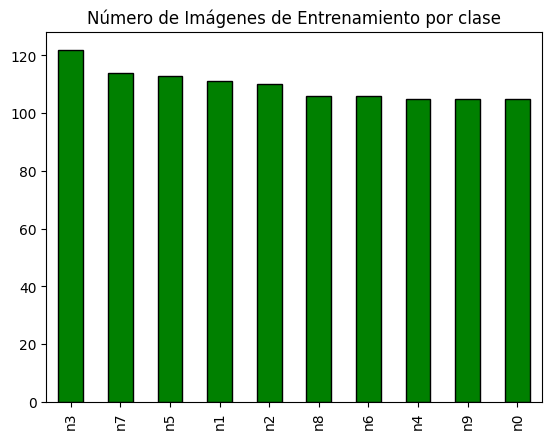

In [4]:
pd.Series(glob.glob("../training/*/*")).str.split("/", expand = True)[2].value_counts().plot(kind = "bar", title = "Número de Imágenes de Entrenamiento por clase", color = "green", edgecolor = "k");


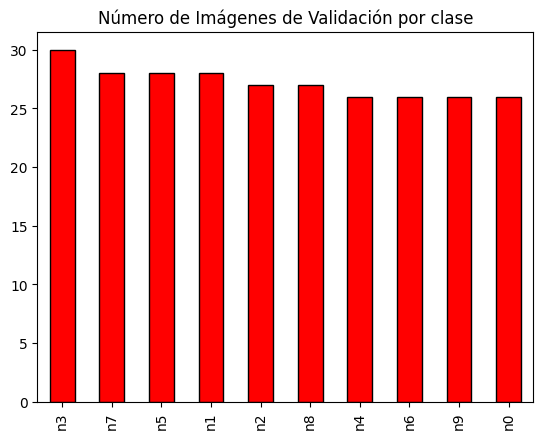

In [5]:
pd.Series(glob.glob("../validation/*/*")).str.split("/", expand = True)[2].value_counts().plot(kind = "bar", title = "Número de Imágenes de Validación por clase", color = "red", edgecolor = "k");

### Muestra de Imágenes a utilizar en entrenamiento

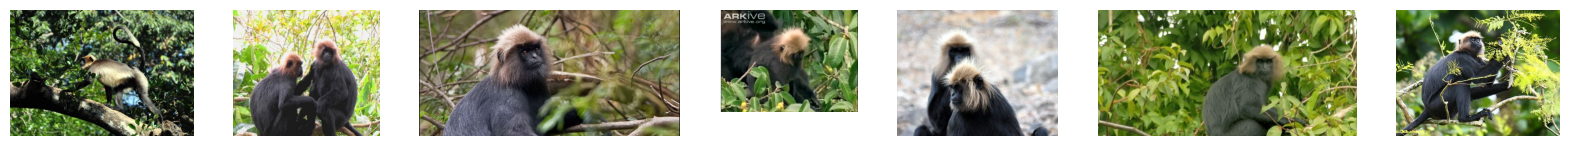

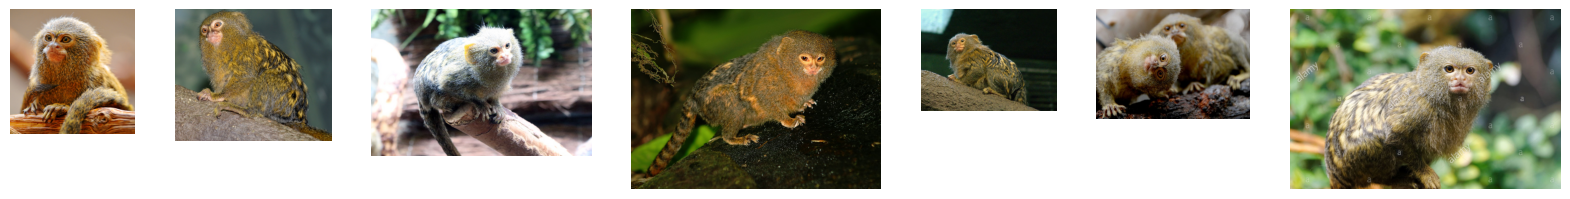

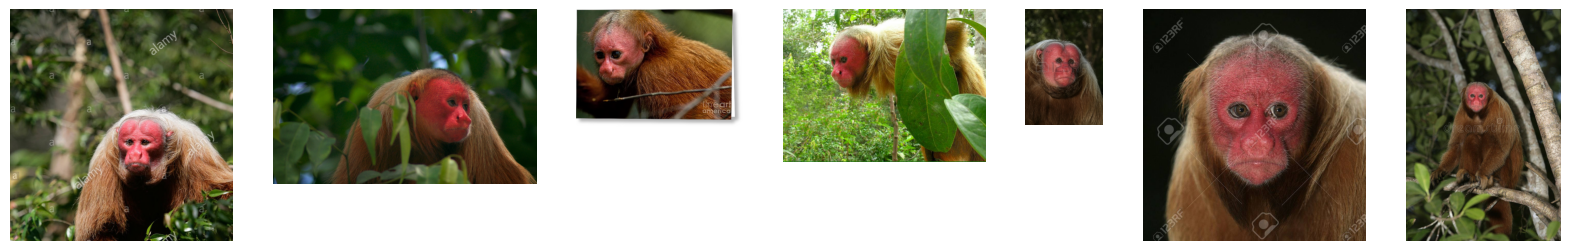

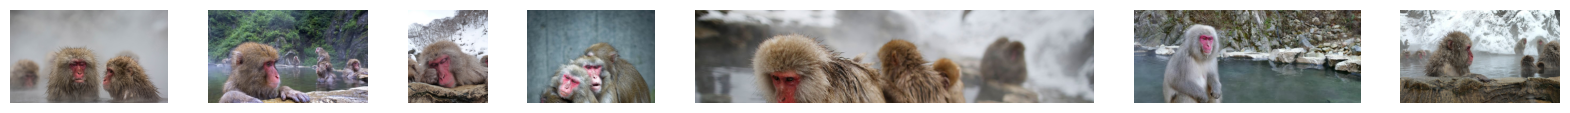

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_5(cl, n = 7, figsize=(10,10)):
    images = glob.glob(f"../training/{cl}/*")[:n]
    fig = plt.figure(1, figsize)
    grid = ImageGrid(fig, 111,
                        nrows_ncols=(1, n),
                        axes_pad=0.4,
                        )

    for img, axes in zip(images,grid):
        axes.axis('off')
        axes.imshow(Image.open(img))
    plt.show()
        
plot_5("n9", figsize = (20,20))
plot_5("n4", figsize = (20,20))
plot_5("n2", figsize = (20,20))
plot_5("n3", figsize = (20,20))

## Modelamiento

### Preprocesamiento de los Datos

In [7]:
class Transforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

## LightningDataModule

El LightningDataModule permite cargar los datos y aplicar las transformaciones necesarias a medida que se va cargando el dataset.

In [8]:
class MonkeyDataModule(pl.LightningDataModule):
    def __init__(self, train_path, test_path, train_transform = None, test_transform = None, bs = 32):
        super().__init__()
        self.train_path = train_path
        self.test_path = test_path
        self.bs = bs
        if train_transform is None:
            self.train_transform = A.Compose([ToTensorV2()])
        else:
            self.train_transform = train_transform
        
        if test_transform is None:
            self.test_transform = A.Compose([ToTensorV2()])
        else:
            self.test_transform = test_transform
        
    def setup(self, stage = None):
        self.train_data = datasets.ImageFolder(self.train_path, Transforms(transforms=self.train_transform))
        self.test_data = datasets.ImageFolder(self.test_path,  Transforms(transforms=self.test_transform))

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size = self.bs, num_workers = 6, pin_memory = True, shuffle = True)
    def val_dataloader(self):
        return DataLoader(self.test_data, batch_size = self.bs, num_workers = 6, pin_memory = True, shuffle = False)
    def predict_dataloader(self):
        return DataLoader(self.test_data, batch_size = self.bs, num_workers = 6, pin_memory = True, shuffle = False)
    
    
dm = MonkeyDataModule("../training/", "../validation/")

## Arquitecturas

#### Vanilla CNN

In [9]:
class VanillaCNN(nn.Module):
    def __init__(self, num_classes, n_channels = 3):
        super().__init__()
        self.conv1 = self.CNN_block(n_channels, 128)
        self.conv2 = self.CNN_block(128, 256)
        self.conv3 = self.CNN_block(256, 512)
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(256) # filtros x tamaño
        self.fc2 = nn.Linear(256, num_classes) # filtros x tamaño
    
    @staticmethod
    def CNN_block(c_in, c_out, k = 3, p = 1, s = 1, pk = 2, ps = 2):
        return nn.Sequential(
                nn.Conv2d(in_channels = c_in, out_channels= c_out, kernel_size = k, padding = p, stride = s),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = pk, stride = ps)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

cnn = VanillaCNN(num_classes=10)
torchinfo.summary(cnn)

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Param #
VanillaCNN                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       3,584
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       295,168
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       1,180,160
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
├─Flatten: 1-4                           --
├─LazyLinear: 1-5                        --
├─Linear: 1-6                            2,570
Total params: 1,481,482
Trainable params: 1,481,482
Non-trainable params: 0

#### EfficientNetB0

In [10]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes, freeze = False):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes = 0)
        if freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
                
        self.clf = nn.Sequential(
            nn.LazyLinear(512),
            nn.Linear(512, self.num_classes)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.clf(x)
        return x
    
eff = EfficientNetB0(num_classes=10)
torchinfo.summary(eff)

Layer (type:depth-idx)                             Param #
EfficientNetB0                                     --
├─EfficientNet: 1-1                                --
│    └─Conv2d: 2-1                                 864
│    └─BatchNormAct2d: 2-2                         64
│    │    └─Identity: 3-1                          --
│    │    └─SiLU: 3-2                              --
│    └─Sequential: 2-3                             --
│    │    └─Sequential: 3-3                        1,448
│    │    └─Sequential: 3-4                        16,714
│    │    └─Sequential: 3-5                        46,640
│    │    └─Sequential: 3-6                        242,930
│    │    └─Sequential: 3-7                        543,148
│    │    └─Sequential: 3-8                        2,026,348
│    │    └─Sequential: 3-9                        717,232
│    └─Conv2d: 2-4                                 409,600
│    └─BatchNormAct2d: 2-5                         2,560
│    │    └─Identity: 3-10         

#### ResNet

In [11]:
class Resnet34(nn.Module):
    def __init__(self, num_classes, freeze = False):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name="resnet34", pretrained=True, num_classes = 0)
        if freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        self.clf = nn.Sequential(
            nn.LazyLinear(256),
            nn.Linear(256,num_classes))
    def forward(self, x):
        x = self.backbone(x)
        return self.clf(x)
    
resnet34 = Resnet34(num_classes=10)
torchinfo.summary(resnet34)

Layer (type:depth-idx)                        Param #
Resnet34                                      --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   73,984
│    │    └─BasicBlock: 3-2                   73,984
│    │    └─BasicBlock: 3-3                   73,984
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-4                   230,144
│    │    └─BasicBlock: 3-5                   295,424
│    │    └─BasicBlock: 3-6                   295,424
│    │    └─BasicBlock: 3-7                   295,424
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-8                   919,040
│    │    └─BasicBlock: 3-9                   1,180,672
│    │    └─Basi

#### AlexNet

In [12]:
class Alexnet(nn.Module):
    def __init__(self, num_classes, freeze = False):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = models.alexnet(weights='DEFAULT')
        if freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
        self.backbone.classifier =  nn.Sequential(
                                    nn.Linear(9216, 1024),
                                    nn.ReLU(),
                                    nn.Dropout(0.4),
                                    nn.Linear(1024, num_classes))
    def forward(self, x):
        x = self.backbone(x)
        return x

alexnet = Alexnet(num_classes=10)
torchinfo.summary(alexnet)

Layer (type:depth-idx)                   Param #
Alexnet                                  --
├─AlexNet: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  23,296
│    │    └─ReLU: 3-2                    --
│    │    └─MaxPool2d: 3-3               --
│    │    └─Conv2d: 3-4                  307,392
│    │    └─ReLU: 3-5                    --
│    │    └─MaxPool2d: 3-6               --
│    │    └─Conv2d: 3-7                  663,936
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  884,992
│    │    └─ReLU: 3-10                   --
│    │    └─Conv2d: 3-11                 590,080
│    │    └─ReLU: 3-12                   --
│    │    └─MaxPool2d: 3-13              --
│    └─AdaptiveAvgPool2d: 2-2            --
│    └─Sequential: 2-3                   --
│    │    └─Linear: 3-14                 9,438,208
│    │    └─ReLU: 3-15                   --
│    │    └─Dropout: 3-16               

#### Loop de Entrenamiento

In [13]:
class MonkeySpeciesClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self,x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = torch.argmax(self(x), dim = 1)
        return y_hat
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Training

## Vanilla CNN

In [14]:
transforms = A.Compose([
    A.Resize(256,256),
    A.CenterCrop(224, 224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
])

In [15]:
dm = MonkeyDataModule(
    train_path="../training/", 
    test_path="../validation/", 
    train_transform=transforms,
    test_transform=transforms)

cnn = VanillaCNN(num_classes=10)
model = MonkeySpeciesClassifier(cnn)

mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1, 
    callbacks=[mc], 
    #fast_dev_run=True,
    #overfit_batches=1
)

trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:410: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | VanillaCNN       | 1.5 M 
1 | criterion | CrossEntropyLoss | 0     
---------------------------------------------

A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


A Jupyter Widget

A Jupyter Widget

Epoch 0, global step 35: 'val_loss' reached 2.24864 (best 2.24864), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=0-step=35.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 70: 'val_loss' reached 2.10818 (best 2.10818), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=1-step=70.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 105: 'val_loss' reached 1.70300 (best 1.70300), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=2-step=105.ckpt' as top 1


A Jupyter Widget

Epoch 3, global step 140: 'val_loss' reached 1.58277 (best 1.58277), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=3-step=140.ckpt' as top 1


A Jupyter Widget

Epoch 4, global step 175: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 5, global step 210: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 6, global step 245: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 7, global step 280: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 8, global step 315: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 9, global step 350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

              precision    recall  f1-score   support

          n0     0.3077    0.4615    0.3692        26
          n1     0.5556    0.3571    0.4348        28
          n2     0.7083    0.6296    0.6667        27
          n3     0.5294    0.6000    0.5625        30
          n4     0.5625    0.3462    0.4286        26
          n5     0.3810    0.2857    0.3265        28
          n6     0.5909    0.5000    0.5417        26
          n7     0.4138    0.4286    0.4211        28
          n8     0.4186    0.6667    0.5143        27
          n9     0.3462    0.3462    0.3462        26

    accuracy                         0.4632       272
   macro avg     0.4814    0.4622    0.4611       272
weighted avg     0.4820    0.4632    0.4621       272



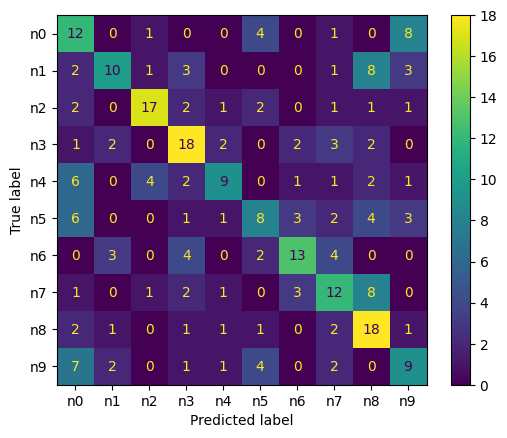

In [16]:
def get_predictions(model, dm):
    output = trainer.predict(model, datamodule=dm)
    y_pred = []
    for item in output:
        y_pred.extend(item.cpu().numpy())
    y_test = dm.test_data.targets
    return y_test, y_pred 


y_test, y_pred = get_predictions(model, dm) 
print(classification_report(y_test, y_pred, digits = 4, target_names=dm.test_data.classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dm.test_data.classes)

# Alexnet Frozen

In [17]:
alexnet = Alexnet(num_classes=10, freeze=True)
model = MonkeySpeciesClassifier(alexnet)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

In [18]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1, 
    callbacks=[mc], 
    #fast_dev_run=True,
    #overfit_batches=1
)

trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Alexnet          | 11.9 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
9.4 M     Trainable params
2.5 M     Non-trainable params
11.9 M    Total params
47.673    Total estimated model params size (MB)


A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


A Jupyter Widget

A Jupyter Widget

Epoch 0, global step 35: 'val_loss' reached 0.43076 (best 0.43076), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=0-step=35.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 70: 'val_loss' reached 0.36677 (best 0.36677), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=1-step=70.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 105: 'val_loss' reached 0.27118 (best 0.27118), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=2-step=105.ckpt' as top 1


A Jupyter Widget

Epoch 3, global step 140: 'val_loss' reached 0.24500 (best 0.24500), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=3-step=140-v1.ckpt' as top 1


A Jupyter Widget

Epoch 4, global step 175: 'val_loss' reached 0.23472 (best 0.23472), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=4-step=175.ckpt' as top 1


A Jupyter Widget

Epoch 5, global step 210: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 6, global step 245: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 7, global step 280: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 8, global step 315: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 9, global step 350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

              precision    recall  f1-score   support

          n0     0.9615    0.9615    0.9615        26
          n1     0.8438    0.9643    0.9000        28
          n2     1.0000    0.9630    0.9811        27
          n3     1.0000    0.8333    0.9091        30
          n4     0.9259    0.9615    0.9434        26
          n5     0.9630    0.9286    0.9455        28
          n6     0.8387    1.0000    0.9123        26
          n7     1.0000    0.9286    0.9630        28
          n8     0.9643    1.0000    0.9818        27
          n9     0.9583    0.8846    0.9200        26

    accuracy                         0.9412       272
   macro avg     0.9456    0.9425    0.9418       272
weighted avg     0.9464    0.9412    0.9415       272



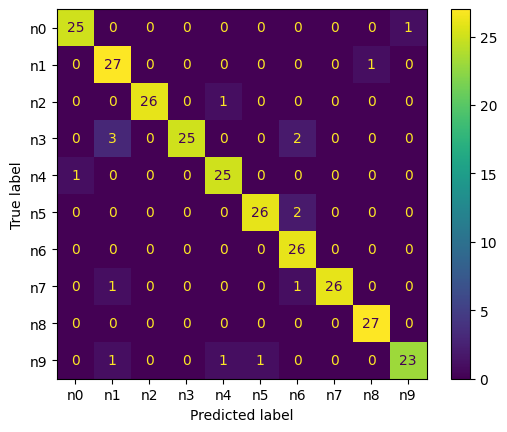

In [19]:
y_test, y_pred = get_predictions(model, dm) 
print(classification_report(y_test, y_pred, digits = 4, target_names=dm.test_data.classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dm.test_data.classes)

## AlexNet no Freeze

In [20]:
alexnet = Alexnet(num_classes=10, freeze=False)
model = MonkeySpeciesClassifier(alexnet)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1, 
    callbacks=[mc], 
    #fast_dev_run=True,
    #overfit_batches=1
)

trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Alexnet          | 11.9 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.673    Total estimated model params size (MB)


A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


A Jupyter Widget

A Jupyter Widget

Epoch 0, global step 35: 'val_loss' reached 2.30248 (best 2.30248), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=0-step=35.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 70: 'val_loss' reached 2.30217 (best 2.30217), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=1-step=70.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 105: 'val_loss' reached 2.30206 (best 2.30206), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=2-step=105.ckpt' as top 1


A Jupyter Widget

Epoch 3, global step 140: 'val_loss' reached 2.30184 (best 2.30184), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=3-step=140-v1.ckpt' as top 1


A Jupyter Widget

Epoch 4, global step 175: 'val_loss' reached 2.30178 (best 2.30178), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=4-step=175-v1.ckpt' as top 1


A Jupyter Widget

Epoch 5, global step 210: 'val_loss' reached 2.30173 (best 2.30173), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=5-step=210-v2.ckpt' as top 1


A Jupyter Widget

Epoch 6, global step 245: 'val_loss' reached 2.30168 (best 2.30168), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=6-step=245-v3.ckpt' as top 1


A Jupyter Widget

Epoch 7, global step 280: 'val_loss' reached 2.30167 (best 2.30167), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=7-step=280-v3.ckpt' as top 1


A Jupyter Widget

Epoch 8, global step 315: 'val_loss' reached 2.30167 (best 2.30167), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=8-step=315-v1.ckpt' as top 1


A Jupyter Widget

Epoch 9, global step 350: 'val_loss' reached 2.30165 (best 2.30165), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=9-step=350-v5.ckpt' as top 1


A Jupyter Widget

Epoch 10, global step 385: 'val_loss' reached 2.30161 (best 2.30161), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=10-step=385-v1.ckpt' as top 1


A Jupyter Widget

Epoch 11, global step 420: 'val_loss' reached 2.30160 (best 2.30160), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=11-step=420.ckpt' as top 1


A Jupyter Widget

Epoch 12, global step 455: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 13, global step 490: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 14, global step 525: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 15, global step 560: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 16, global step 595: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 17, global step 630: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 18, global step 665: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 19, global step 700: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 20, global step 735: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 21, global step 770: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 22, global step 805: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 23, global step 840: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 24, global step 875: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 25, global step 910: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 26, global step 945: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 27, global step 980: 'val_loss' reached 2.30159 (best 2.30159), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=27-step=980.ckpt' as top 1


A Jupyter Widget

Epoch 28, global step 1015: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 29, global step 1050: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=30` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

              precision    recall  f1-score   support

          n0     0.0000    0.0000    0.0000        26
          n1     0.0000    0.0000    0.0000        28
          n2     0.0000    0.0000    0.0000        27
          n3     0.1103    1.0000    0.1987        30
          n4     0.0000    0.0000    0.0000        26
          n5     0.0000    0.0000    0.0000        28
          n6     0.0000    0.0000    0.0000        26
          n7     0.0000    0.0000    0.0000        28
          n8     0.0000    0.0000    0.0000        27
          n9     0.0000    0.0000    0.0000        26

    accuracy                         0.1103       272
   macro avg     0.0110    0.1000    0.0199       272
weighted avg     0.0122    0.1103    0.0219       272



/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

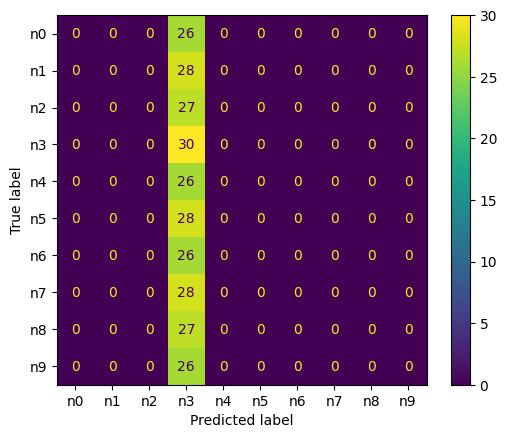

In [21]:
y_test, y_pred = get_predictions(model, dm) 
print(classification_report(y_test, y_pred, digits = 4, target_names=dm.test_data.classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dm.test_data.classes)

## Resnet No Freeze

In [22]:
resnet34 = Resnet34(num_classes=10, freeze=False)
model = MonkeySpeciesClassifier(resnet34)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1, 
    callbacks=[mc], 
    #fast_dev_run=True,
    #overfit_batches=1
)

trainer.fit(model, dm)

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Resnet34         | 21.3 M
1 | criterion | CrossEntropyLoss | 0     
-------------------

A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


A Jupyter Widget

A Jupyter Widget

Epoch 0, global step 35: 'val_loss' reached 3.63903 (best 3.63903), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=0-step=35.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 70: 'val_loss' reached 0.52845 (best 0.52845), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=1-step=70.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 105: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 3, global step 140: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 4, global step 175: 'val_loss' reached 0.44965 (best 0.44965), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=4-step=175-v1.ckpt' as top 1


A Jupyter Widget

Epoch 5, global step 210: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 6, global step 245: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 7, global step 280: 'val_loss' reached 0.14904 (best 0.14904), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=7-step=280-v3.ckpt' as top 1


A Jupyter Widget

Epoch 8, global step 315: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 9, global step 350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

              precision    recall  f1-score   support

          n0     0.7778    0.8077    0.7925        26
          n1     1.0000    0.8571    0.9231        28
          n2     0.9643    1.0000    0.9818        27
          n3     0.9643    0.9000    0.9310        30
          n4     0.9259    0.9615    0.9434        26
          n5     1.0000    0.8214    0.9020        28
          n6     0.9565    0.8462    0.8980        26
          n7     0.7179    1.0000    0.8358        28
          n8     0.8889    0.8889    0.8889        27
          n9     0.8846    0.8846    0.8846        26

    accuracy                         0.8971       272
   macro avg     0.9080    0.8967    0.8981       272
weighted avg     0.9089    0.8971    0.8986       272



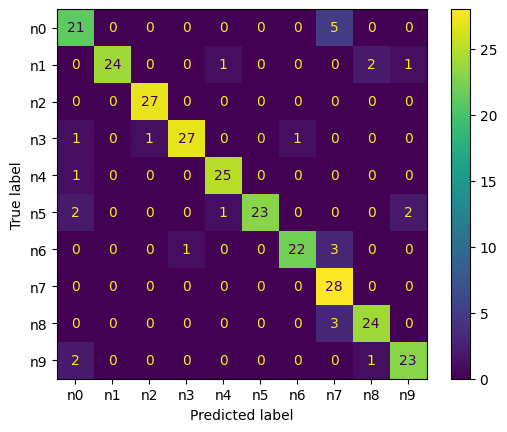

In [23]:
y_test, y_pred = get_predictions(model, dm) 
print(classification_report(y_test, y_pred, digits = 4, target_names=dm.test_data.classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dm.test_data.classes)

## Resnet Frozen

In [24]:
resnet34 = Resnet34(num_classes=10, freeze=True)
model = MonkeySpeciesClassifier(resnet34)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1, 
    callbacks=[mc], 
    #fast_dev_run=True,
    #overfit_batches=1
)

trainer.fit(model, dm)

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Resnet34         | 21.3 M
1 | criterion | CrossEntropyLoss | 0     
-------------------

A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


A Jupyter Widget

A Jupyter Widget

Epoch 0, global step 35: 'val_loss' reached 0.19635 (best 0.19635), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=0-step=35.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 70: 'val_loss' reached 0.15181 (best 0.15181), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=1-step=70.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 105: 'val_loss' reached 0.10427 (best 0.10427), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=2-step=105.ckpt' as top 1


A Jupyter Widget

Epoch 3, global step 140: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 4, global step 175: 'val_loss' reached 0.08220 (best 0.08220), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=4-step=175-v1.ckpt' as top 1


A Jupyter Widget

Epoch 5, global step 210: 'val_loss' reached 0.07592 (best 0.07592), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=5-step=210-v2.ckpt' as top 1


A Jupyter Widget

Epoch 6, global step 245: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 7, global step 280: 'val_loss' reached 0.06859 (best 0.06859), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=7-step=280-v4.ckpt' as top 1


A Jupyter Widget

Epoch 8, global step 315: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 9, global step 350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

              precision    recall  f1-score   support

          n0     0.9231    0.9231    0.9231        26
          n1     1.0000    1.0000    1.0000        28
          n2     0.9286    0.9630    0.9455        27
          n3     1.0000    0.9333    0.9655        30
          n4     0.9615    0.9615    0.9615        26
          n5     0.9655    1.0000    0.9825        28
          n6     1.0000    0.9615    0.9804        26
          n7     0.9655    1.0000    0.9825        28
          n8     1.0000    1.0000    1.0000        27
          n9     0.9231    0.9231    0.9231        26

    accuracy                         0.9669       272
   macro avg     0.9667    0.9666    0.9664       272
weighted avg     0.9674    0.9669    0.9669       272



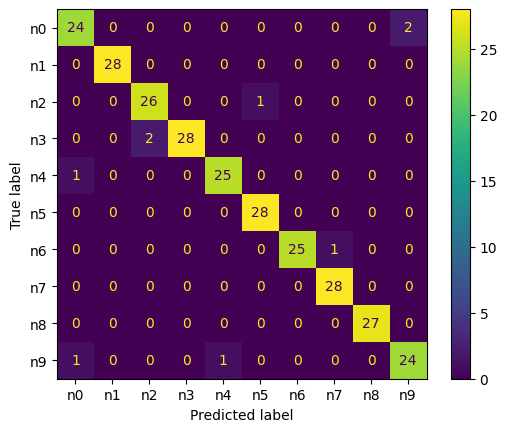

In [25]:
y_test, y_pred = get_predictions(model, dm) 
print(classification_report(y_test, y_pred, digits = 4, target_names=dm.test_data.classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dm.test_data.classes)

## EfficientNet Frozen

In [26]:
effB0 = EfficientNetB0(num_classes=10, freeze=True)
model = MonkeySpeciesClassifier(effB0)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1, 
    callbacks=[mc], 
    #fast_dev_run=True,
    #overfit_batches=1
)

trainer.fit(model, dm)

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EfficientNetB0   | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-------------------

A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


A Jupyter Widget

A Jupyter Widget

Epoch 0, global step 35: 'val_loss' reached 0.18878 (best 0.18878), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=0-step=35.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 70: 'val_loss' reached 0.15235 (best 0.15235), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=1-step=70.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 105: 'val_loss' reached 0.14164 (best 0.14164), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=2-step=105.ckpt' as top 1


A Jupyter Widget

Epoch 3, global step 140: 'val_loss' reached 0.12692 (best 0.12692), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=3-step=140-v1.ckpt' as top 1


A Jupyter Widget

Epoch 4, global step 175: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 5, global step 210: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 6, global step 245: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 7, global step 280: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 8, global step 315: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 9, global step 350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

              precision    recall  f1-score   support

          n0     0.9615    0.9615    0.9615        26
          n1     1.0000    0.8214    0.9020        28
          n2     0.9259    0.9259    0.9259        27
          n3     0.9355    0.9667    0.9508        30
          n4     1.0000    0.9615    0.9804        26
          n5     0.9310    0.9643    0.9474        28
          n6     0.9600    0.9231    0.9412        26
          n7     0.9333    1.0000    0.9655        28
          n8     0.9643    1.0000    0.9818        27
          n9     0.8929    0.9615    0.9259        26

    accuracy                         0.9485       272
   macro avg     0.9504    0.9486    0.9482       272
weighted avg     0.9503    0.9485    0.9481       272



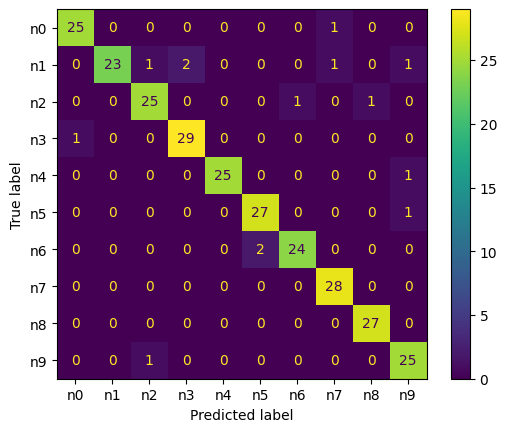

In [27]:
y_test, y_pred = get_predictions(model, dm) 
print(classification_report(y_test, y_pred, digits = 4, target_names=dm.test_data.classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dm.test_data.classes)

## EfficientNet No Freeze

In [28]:
effB0 = EfficientNetB0(num_classes=10, freeze=False)
model = MonkeySpeciesClassifier(effB0)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    #filename = 'best-checkpoint',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss', 
    mode = 'min'
    )
mc.CHECKPOINT_NAME_LAST = 'best-checkpoint-latest'

trainer = pl.Trainer(
    max_epochs=15,
    accelerator="gpu",
    devices=1, 
    callbacks=[mc], 
    #fast_dev_run=True,
    #overfit_batches=1
)

trainer.fit(model, dm)

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EfficientNetB0   | 4.0 M 
1 | criterion | CrossEntropyLoss | 0     
-------------------

A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


A Jupyter Widget

A Jupyter Widget

Epoch 0, global step 35: 'val_loss' reached 0.84982 (best 0.84982), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=0-step=35.ckpt' as top 1


A Jupyter Widget

Epoch 1, global step 70: 'val_loss' reached 0.12763 (best 0.12763), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=1-step=70.ckpt' as top 1


A Jupyter Widget

Epoch 2, global step 105: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 3, global step 140: 'val_loss' reached 0.09929 (best 0.09929), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=3-step=140-v2.ckpt' as top 1


A Jupyter Widget

Epoch 4, global step 175: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 5, global step 210: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 6, global step 245: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 7, global step 280: 'val_loss' reached 0.08808 (best 0.08808), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=7-step=280-v5.ckpt' as top 1


A Jupyter Widget

Epoch 8, global step 315: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 9, global step 350: 'val_loss' reached 0.05319 (best 0.05319), saving model to '/home/datacuber/Documents/MSDS/Neural Net/codes/checkpoints/epoch=9-step=350-v5.ckpt' as top 1


A Jupyter Widget

Epoch 10, global step 385: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 11, global step 420: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 12, global step 455: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 13, global step 490: 'val_loss' was not in top 1


A Jupyter Widget

Epoch 14, global step 525: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=15` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

              precision    recall  f1-score   support

          n0     0.9630    1.0000    0.9811        26
          n1     1.0000    1.0000    1.0000        28
          n2     1.0000    0.9630    0.9811        27
          n3     0.9677    1.0000    0.9836        30
          n4     1.0000    0.9231    0.9600        26
          n5     1.0000    1.0000    1.0000        28
          n6     0.9615    0.9615    0.9615        26
          n7     0.9655    1.0000    0.9825        28
          n8     0.9643    1.0000    0.9818        27
          n9     1.0000    0.9615    0.9804        26

    accuracy                         0.9816       272
   macro avg     0.9822    0.9809    0.9812       272
weighted avg     0.9821    0.9816    0.9815       272



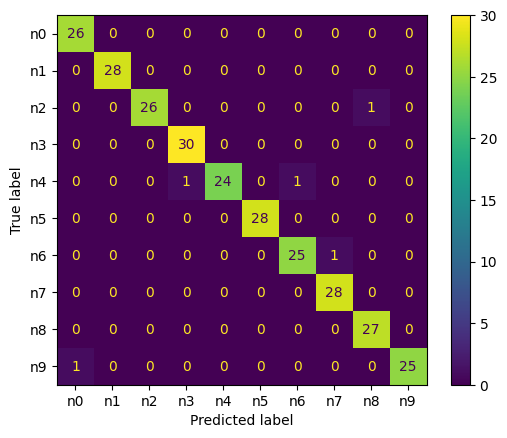

In [29]:
y_test, y_pred = get_predictions(model, dm) 
print(classification_report(y_test, y_pred, digits = 4, target_names=dm.test_data.classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dm.test_data.classes)